## Bayesian inference on Covid fatality rates
### Josh Villarreal
---

In [65]:
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import optimize
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### 1. Preprocessing
1. Preprocess NYT data: read in, parse to most recent day, and calculate cumulative death rate and store result in column `death_rate`
2. Preprocess PM data: remove irrelevant columns, rename columns, modify datatypes of certain columns.
3. Zip together the NYT and PM data by the FIP code and the date. Split into training and test sets based on 85% training and 15% testing.

**Preprocess NYT data**

Here we calculate the cumulative death rate and store in the column `death_rate`. We also modify the `date` column to a datetime object.

In [66]:
# Read in NYT data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
nyt_df = pd.read_csv(url,index_col=None,parse_dates=[0])

# Calculate cumulative death rate
nyt_df['death_rate'] = nyt_df['deaths'] / nyt_df['cases']

# Convert date column to datetime object
nyt_df['date'] = pd.to_datetime(nyt_df['date'], format='%d/%m/%Y')

**Preprocess PM data**

Here, we drop the unnecessary columns `Unnamed: 0`, `Country_Region` (US for all entries), `Last_Update` (encoded in the `date` column), the `Province_State`, `Combined_Key`, and `Admin2` columns (all of which are summarized in the `fips` column), `year.x` (2016 for all entries), `year.y` (2012 for all entries), `older_Population` (encoded in `older_pecent`), `state`, `hash`, `dateChecked`, `Abbrev`, and `Recovered` (since we only have zero values listed in the DataFrame. We're also dropping non-cumulative data like `Confirmed`, `Deaths`, `Recovered`, `Active`, and columns with all NaNs like `beds`, `pending`, `hospitalizedCurrently`, `hospitalizedCumulative`, `inIcuCurrently`, `inIcuCumulative`, `onVentilatorCurrently`, `onVentilatorCumulative`, `recovered`, `death`, `hospitalized`

We also rename the `Long_` column to `Long`, `older_pecent` to `older_percent`, and `Deaths` to `county_deaths`.

Finally, we modify the `date` column to change the datatype from an int to a TimeStamp object.

In [67]:
# Read in data
data_04_24 = pd.read_csv('../PM_COVID-master/processed_data_04-24-2020.csv')
data_04_30 = pd.read_csv('../PM_COVID-master/processed_data_04-30-2020.csv')
data_05_02 = pd.read_csv('../PM_COVID-master/processed_data_05-02-2020.csv')
data_05_03 = pd.read_csv('../PM_COVID-master/processed_data_05-03-2020.csv')

# Concatenate dataframes
frames = [data_04_24, data_04_30, data_05_02, data_05_03]
data_big = pd.concat(frames, ignore_index=True)

In [68]:
# Drop relevant columns
to_drop = ['Unnamed: 0', 'Country_Region', 'Last_Update', 'Province_State', 'Admin2', 'year.x', 
           'year.y', 'older_Population', 'state', 'hash', 'dateChecked', 'Abbrev', 'Recovered', 'Confirmed',
           'Deaths', 'Active', 'beds', 'pending', 'hospitalizedCurrently', 'hospitalizedCumulative', 
           'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
           'death', 'hospitalized']
data_big = data_big.drop(to_drop, axis=1)

# Rename relevant columns
to_rename = {'Long_': 'Long', 'older_pecent': 'older_percent', 'Deaths': 'county_deaths'}
data_big = data_big.rename(columns=to_rename)

# Change date column to a TimeStamp day
data_big['date'] = pd.to_datetime(data_big['date'], format='%Y%m%d')

In [69]:
data_big.shape

(12344, 40)

**Zip together NYT and PM data**

Here we append the `cases`, `deaths`, and `death_rate` columns from the NYT dataset (encoded in `nyt_df`) to the PM data set (encoded in `data_big`) based on the FIPS and the date of measure. We store this information in `data_big` as `cum_cases`, `cum_deaths`, and `death_rate`, respectively.

We also renumber the `fips` column to start at $0$ and incriment by $1$, storing the key in the dictionaries `fip2idx` and `idx2fip`. We do the same for the `date` column.

Finally, we split the dataframe into train and test sets.

In [70]:
# Add cases, deaths, and death_rate columns from nyt_df to data_big
data_big = data_big.merge(nyt_df[['fips', 'date', 'cases', 'deaths', 'death_rate']], 
                          left_on=['fips', 'date'], right_on=['fips', 'date'])

# Rename relevant columns
to_rename2 = {'cases': 'cum_cases', 'deaths': 'cum_deaths'}
data_big = data_big.rename(columns=to_rename2)

In [71]:
# Create hashtables for fips fip2idx and idx2fip
fips = sorted(set(data_big.fips.values))
fip2idx = {fips[i]: i for i in range(len(fips))}
idx2fip = {i: fips[i] for i in range(len(fips))}

# Replace fips using hashtable
data_big['fips'] = data_big['fips'].map(fip2idx)

# Create hashtables for dates date2idx and idx2date
dates = sorted(set(data_big.date.values))
date2idx = {dates[i]: i for i in range(len(dates))}
idx2date = {i: dates[i] for i in range(len(dates))}

# Replace dates using hastables
data_big['date'] = data_big['date'].map(date2idx)

In [72]:
# Drop NaN rows and create predictors matrix
data_big = data_big.dropna()
X_big = data_big[['mean_pm25', 'mean_winter_temp', 'mean_summer_temp', 'Lat', 'Long',
       'poverty', 'popdensity', 'medianhousevalue', 'pct_blk',
       'medhouseholdincome', 'pct_owner_occ', 'hispanic', 'education',
       'population', 'pct_asian', 'pct_native', 'pct_white', 'q_popdensity',
       'smoke_rate', 'mean_bmi', 'Population', 'older_percent',
       'date', 'population_frac_county','cum_cases',
       'cum_deaths', 'death_rate']]

# Rescale data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(X_big) 
X_big.loc[:,:] = scaled_values
X_big['death_rate'] = data_big['death_rate']

# Split into 85% train and 15% test
X_train, X_test = train_test_split(X_big, test_size=.15)

/Users/Josh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Josh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


---
### 2. Basic intercept model.
From the data available in `data_big`, we assume a basic intercept linear regression model with linear dependencies on the variables:
- `mean_pm25`, `mean_winter_temp`, `mean_summer_temp`, `Lat`, `Long`, `poverty`, `popdensity`, `medianhousevalue`, `pct_blk`, `medhouseholdincome`, `pct_owner_occ`, `hispanic`, `education`, `population`, `pct_asian`, `pct_native`, `pct_white`, `q_popdensity`, `smoke_rate`, `mean_bmi`, `older_percent`, `cum_cases`
- $\displaystyle Y \sim \mathcal{N} (\mu, 0.01), \mu = \sum_k \beta_k x_k$ for $Y$ the death rate, and $\beta_k \sim \mathcal{N} (0, 10000)$.


The goal of this section of the analysis is to figure out which predictors seem to have the most influence on mortality rates.

1. Start by splitting up the relevant predictors from `data_big`
2. Fit the model to the training set `X_train`
3. Plot traceplots of the MCMC samplers for the relevant parameters. Examine convergence based on R-hat values.

**Instantiate relevant predictors**

In [9]:
# Split up data_big columns into relevant model predictors
x_mpm = X_train['mean_pm25']
x_mwt = X_train['mean_winter_temp']
x_mst = X_train['mean_summer_temp']
x_lat = X_train['Lat']
x_lon = X_train['Long']
x_pov = X_train['poverty']
x_den = X_train['popdensity']
x_mhv = X_train['medianhousevalue']
x_blk = X_train['pct_blk']
x_mhi = X_train['medhouseholdincome']
x_poo = X_train['pct_owner_occ']
x_his = X_train['hispanic']
x_edu = X_train['education']
x_pop = X_train['population']
x_asi = X_train['pct_asian']
x_nat = X_train['pct_native']
x_wht = X_train['pct_white']
x_qden = X_train['q_popdensity']
x_smk = X_train['smoke_rate']
x_bmi = X_train['mean_bmi']
x_old = X_train['older_percent']
x_cc = X_train['cum_cases']

**Build and fit the basic model defined below to the training data**

$$Y \sim \mathcal{N} (\mu, 0.01), \mu = \sum_k \beta_k x_k$$ for $Y$ the death rate, and $\beta_k \sim \mathcal{N} (0, 10000)$.

In [10]:
# Fit mixed intercept model to training data
basic_model = pm.Model()

with basic_model:
    
    # Priors for linear terms
    beta_mpm = pm.Normal('beta_mpm', mu=0, sd=100)
    beta_mwt = pm.Normal('beta_mwt', mu=0, sd=100)
    beta_mst = pm.Normal('beta_mst', mu=0, sd=100)
    beta_lat = pm.Normal('beta_lat', mu=0, sd=100)
    beta_lon = pm.Normal('beta_lon', mu=0, sd=100)
    beta_pov = pm.Normal('beta_pov', mu=0, sd=100)
    beta_den = pm.Normal('beta_den', mu=0, sd=100)
    beta_mhv = pm.Normal('beta_mhv', mu=0, sd=100)
    beta_blk = pm.Normal('beta_blk', mu=0, sd=100)
    beta_mhi = pm.Normal('beta_mhi', mu=0, sd=100)
    beta_poo = pm.Normal('beta_poo', mu=0, sd=100)
    beta_his = pm.Normal('beta_his', mu=0, sd=100)
    beta_edu = pm.Normal('beta_edu', mu=0, sd=100)
    beta_pop = pm.Normal('beta_pop', mu=0, sd=100)
    beta_asi = pm.Normal('beta_asi', mu=0, sd=100)
    beta_nat = pm.Normal('beta_nat', mu=0, sd=100)
    beta_wht = pm.Normal('beta_wht', mu=0, sd=100)
    beta_qden = pm.Normal('beta_qden', mu=0, sd=100)
    beta_smk = pm.Normal('beta_smk', mu=0, sd=100)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=100)
    beta_old = pm.Normal('beta_old', mu=0, sd=100)
    beta_cc = pm.Normal('beta_cc', mu=0, sd=100)

    # Likelihood (sampling distribution) of observations
    lam_ij = beta_mpm*x_mpm + beta_mwt*x_mwt + beta_mst*x_mst \
                + beta_lat*x_lat + beta_lon*x_lon + beta_pov*x_pov + beta_den*x_den + beta_mhv*x_mhv \
                + beta_blk*x_blk + beta_mhi*x_mhi + beta_poo*x_poo + beta_his*x_his + beta_edu*x_edu \
                + beta_pop*x_pop + beta_asi*x_asi + beta_nat*x_nat + beta_wht*x_wht + beta_qden*x_qden \
                + beta_smk*x_smk + beta_bmi*x_bmi + beta_old*x_old + beta_cc*x_cc
    Y_obs = pm.Normal('Y_obs', mu=lam_ij, sd=0.1, observed=X_train['death_rate'])

**Traceplots and convergence**

Here we obtain the posterior samples and examine the results of the trace to determine which variables seem to have the most influence on the death rate.

In [11]:
# Sampling
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 2000 posterior samples
    #trace = pm.sample(2000, step, start=start)
    trace = pm.sample(2000, step, start=start)

/Users/Josh/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = 8,742.6:  29%|██▊       | 1430/5000 [00:00<00:01, 1963.93it/s]    

Optimization terminated successfully.
         Current function value: -8742.589625
         Iterations: 7
         Function evaluations: 1436


logp = 8,742.6:  29%|██▊       | 1436/5000 [00:01<00:03, 1065.76it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_cc, beta_old, beta_bmi, beta_smk, beta_qden, beta_wht, beta_nat, beta_asi, beta_pop, beta_edu, beta_his, beta_poo, beta_mhi, beta_blk, beta_mhv, beta_den, beta_pov, beta_lon, beta_lat, beta_mst, beta_mwt, beta_mpm]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [14:46<00:00,  3.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
# Display results
results = pm.summary(trace)
results

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_mpm   0.015  0.011  -0.005    0.037      0.000      0.0    7341.0   
beta_mwt   0.004  0.020  -0.030    0.042      0.000      0.0    2309.0   
beta_mst   0.008  0.018  -0.026    0.042      0.000      0.0    3685.0   
beta_lat   0.017  0.018  -0.015    0.052      0.000      0.0    1867.0   
beta_lon   0.000  0.009  -0.016    0.017      0.000      0.0    5105.0   
beta_pov   0.010  0.015  -0.019    0.038      0.000      0.0    9456.0   
beta_den   0.002  0.032  -0.061    0.061      0.000      0.0    9173.0   
beta_mhv  -0.040  0.026  -0.091    0.007      0.000      0.0    5516.0   
beta_blk   0.023  0.023  -0.020    0.067      0.001      0.0    1819.0   
beta_mhi   0.005  0.021  -0.033    0.045      0.000      0.0    5616.0   
beta_poo   0.011  0.013  -0.013    0.035      0.000      0.0    3818.0   
beta_his   0.005  0.014  -0.021    0.033      0.000      0.0    7902.0   
beta_edu  -0.038  0.015  -0.065   -0.010      0.000      0.0   10147.0   
beta_pop  -0.006  0.045  -0.089    0.077      0.000      0.0    9185.0   
beta_asi   0.026  0.032  -0.036    0.083      0.000      0.0    6015.0   
beta_nat   0.054  0.032  -0.007    0.114      0.001      0.0    2489.0   
beta_wht   0.004  0.022  -0.037    0.047      0.001      0.0    1623.0   
beta_qden  0.009  0.005  -0.001    0.019      0.000      0.0    8092.0   
beta_smk   0.007  0.011  -0.013    0.028      0.000      0.0    7500.0   
beta_bmi  -0.016  0.023  -0.058    0.027      0.000      0.0    7262.0   
beta_old   0.028  0.016  -0.001    0.060      0.000      0.0    9016.0   
beta_cc    0.036  0.035  -0.030    0.102      0.000      0.0    8369.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta_mpm   6154.0    7358.0    5626.0    1.0  
beta_mwt   2309.0    2310.0    3738.0    1.0  
beta_mst   3685.0    3685.0    4570.0    1.0  
beta_lat   1867.0    1869.0    3205.0    1.0  
beta_lon   4784.0    5117.0    5474.0    1.0  
beta_pov   6581.0    9462.0    6781.0    1.0  
beta_den   5215.0    9158.0    6930.0    1.0  
beta_mhv   5516.0    5522.0    6098.0    1.0  
beta_blk   1819.0    1818.0    3150.0    1.0  
beta_mhi   4400.0    5611.0    5601.0    1.0  
beta_poo   3438.0    3858.0    4676.0    1.0  
beta_his   5451.0    7913.0    6259.0    1.0  
beta_edu   9362.0   10157.0    6118.0    1.0  
beta_pop   4508.0    9183.0    6595.0    1.0  
beta_asi   5937.0    6020.0    6695.0    1.0  
beta_nat   2489.0    2490.0    4029.0    1.0  
beta_wht   1623.0    1625.0    2254.0    1.0  
beta_qden  7598.0    8083.0    6671.0    1.0  
beta_smk   4984.0    7503.0    5451.0    1.0  
beta_bmi   5028.0    7269.0    5982.0    1.0  
beta_old   8380.0    9023.0    6962.0    1.0  
beta_cc    7578.0    8369.0    7063.0    1.0

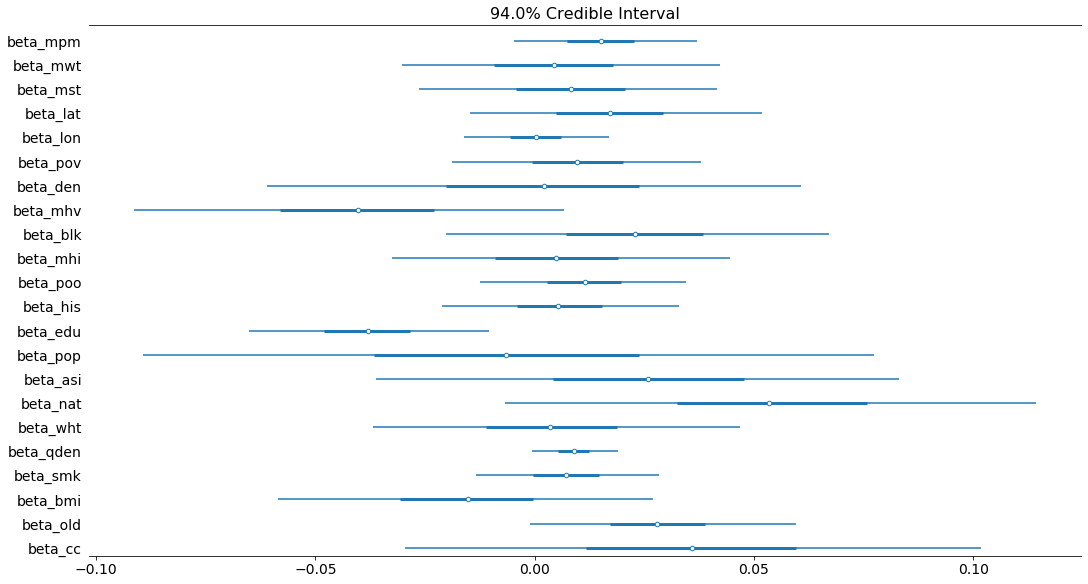

In [24]:
# Plot 94% credible intervals for each beta
axes = pm.plot_forest(trace, kind='forestplot', combined=True, ridgeplot_overlap=3, figsize=(15, 8))

/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

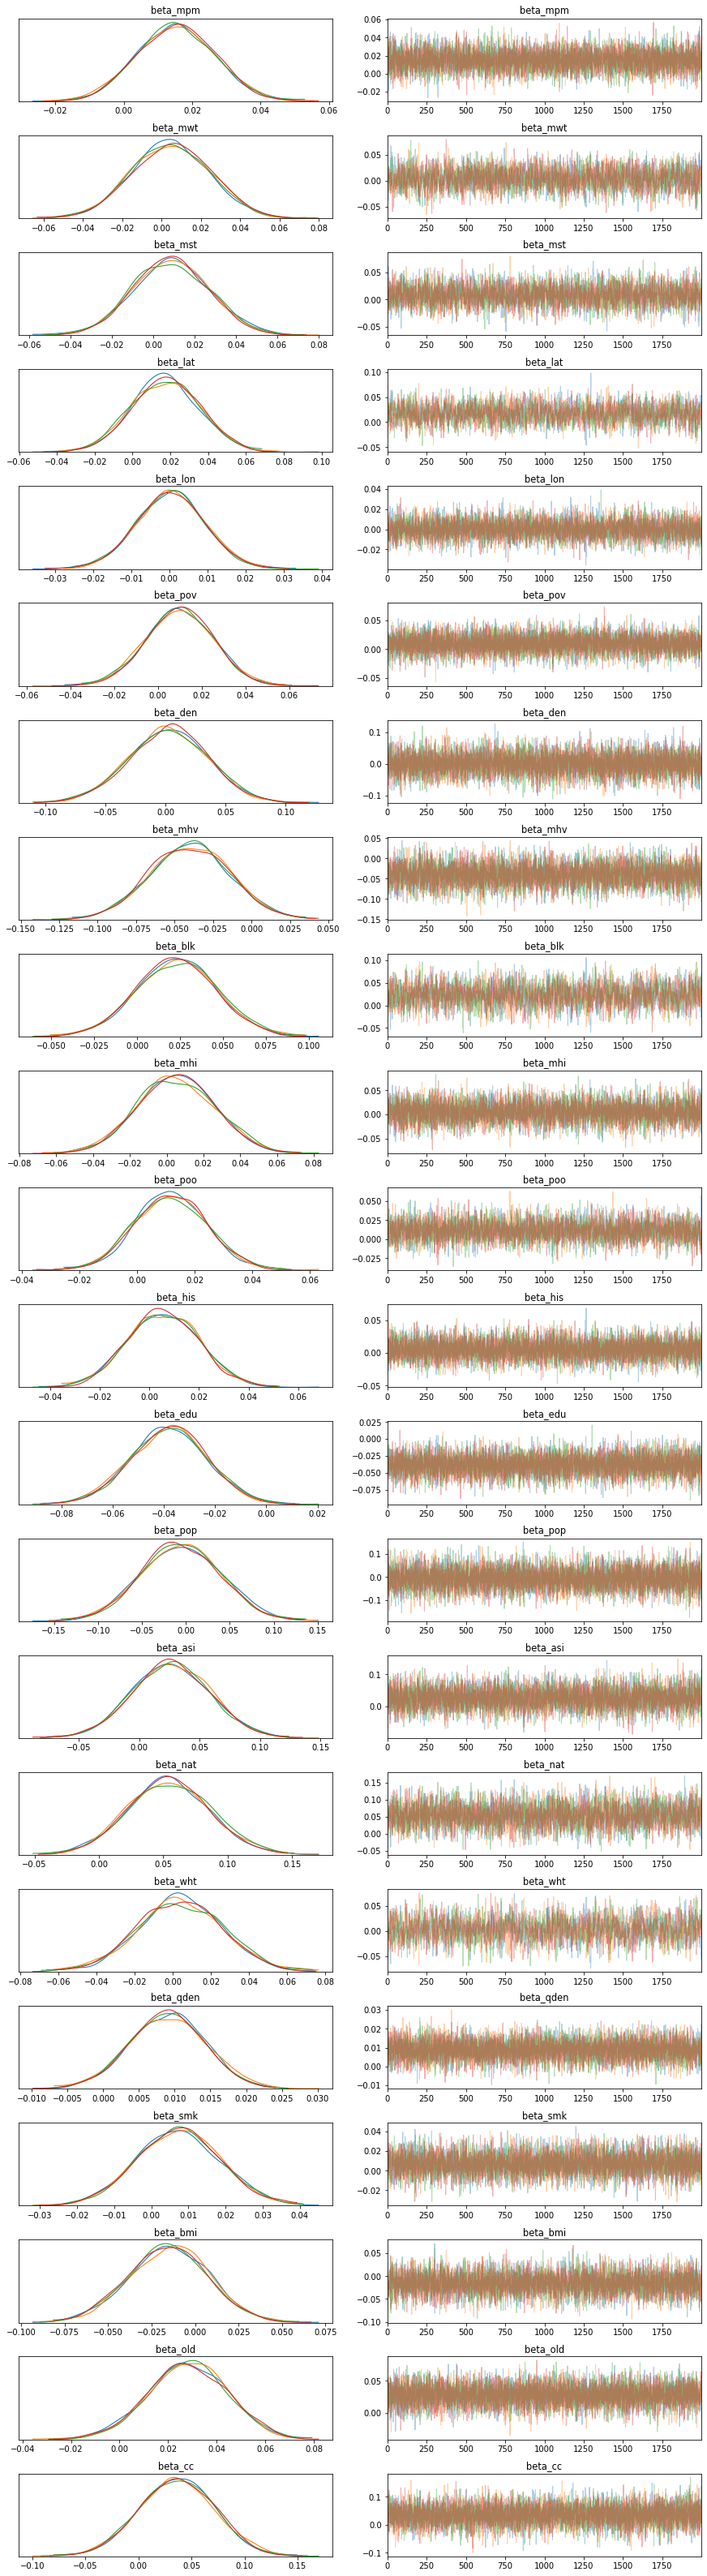

In [22]:
# Create traceplots of most important 
pm.traceplot(trace)
plt.show()

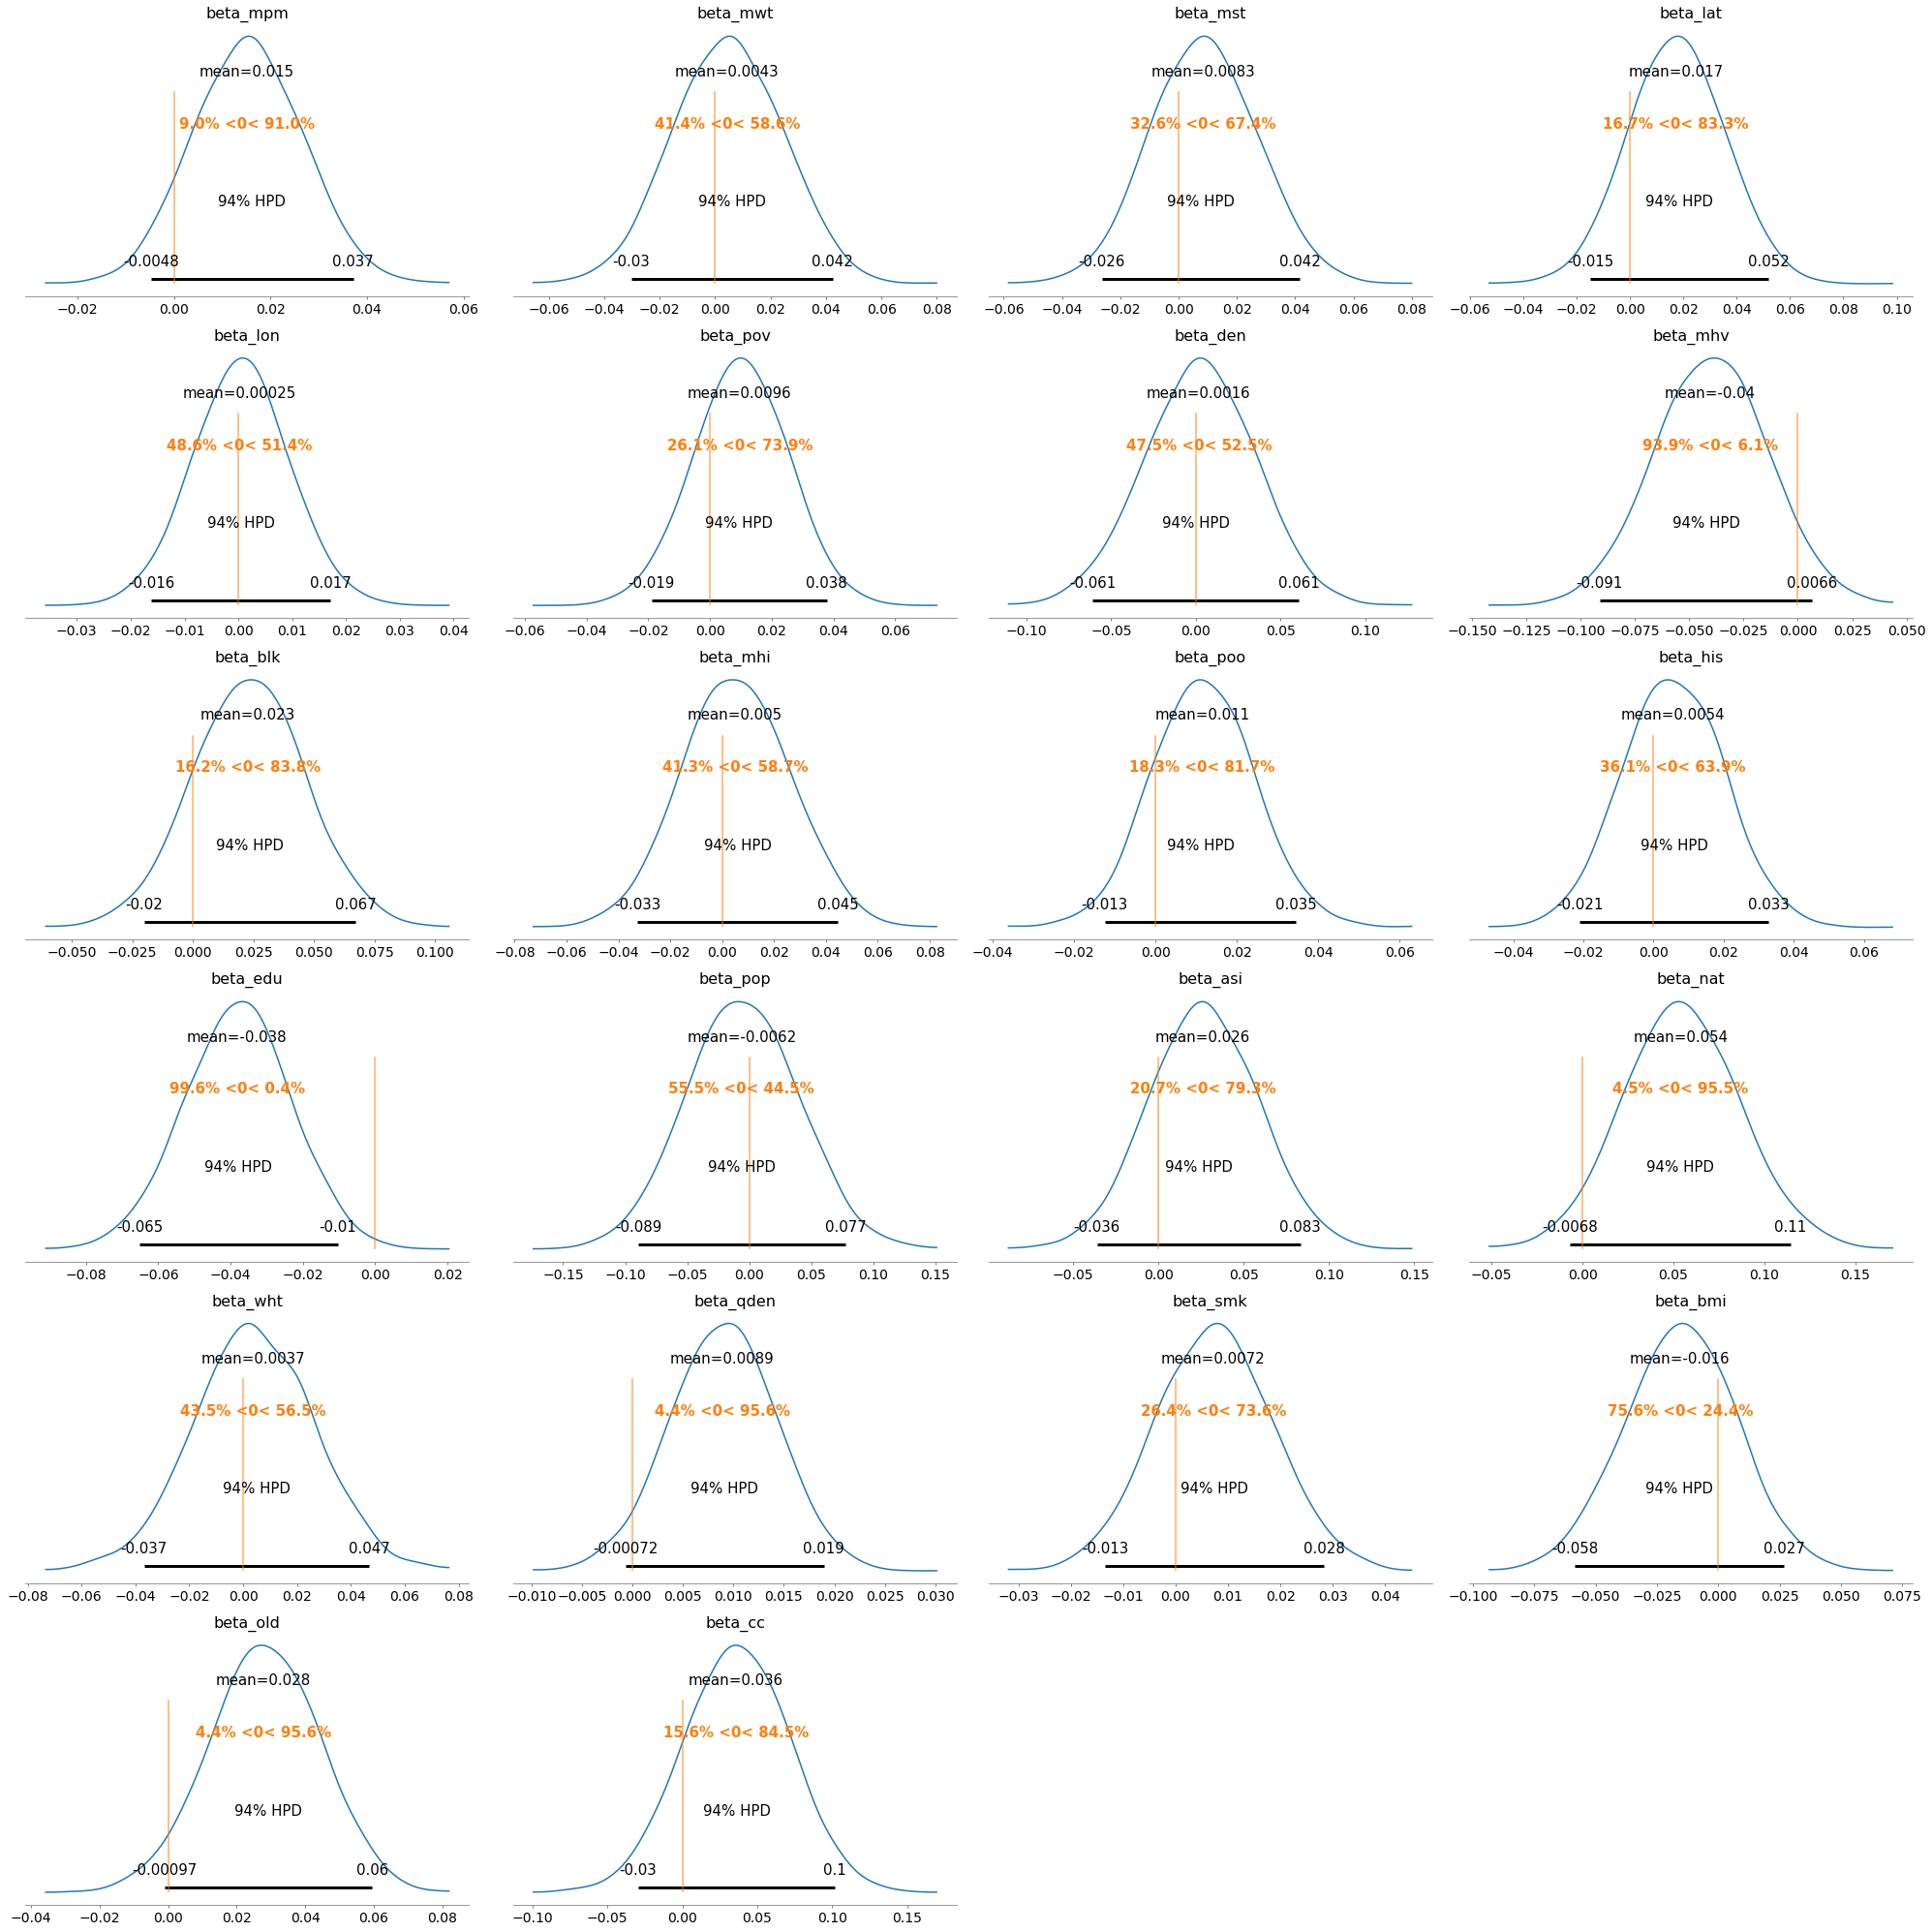

In [25]:
# Plot posterior distributions of parameters
pm.plots.plot_posterior(trace, ref_val=0)
plt.show()

**Conclusions**

It appears as though, based on the R-hat values being 1.0, that all of the coefficients converged correctly. While the forest plot shown above provides a nice aggregation of the distributions of each of the coefficients in the model, the plots of the distributions of the posteriors may be more indicative in determining which predictors are of the most importance. Here are some of the most telling:

- We can say with 91% confidence that the coefficient of the mean particulate matter term $PM_{2.5}$, which encodes the quality of the air in the region, is not just nonzero, but positive. We can be 91% positive that a poorer air quality (and therefore a higher mean particulate matter) increases the death rate of coronavirus.
- We can be 93.9% confident that the coefficient of the median home value is negative, which means that the higher the median home value is in the county, the lower the death rate.
- It's with 99.6% confidence that the lower the education level of the county, the higher the death rate. Conversely, the higher the education level of the county, the lower the death rate.
- It's with 95.5% confidence that the higher the proportion of Native American residents in the county, the higher the death rate.
- It's with 95.6% confidence that the higher the percentage of older residents in the population, the higher the death rate.

There are, however, some parameters that we can eliminate from our model to improve computational efficiency. It seems like the mean winter temperature, the mean summer temperature, the longitude, the population density, the median household income, the population of the county, and the percentage of the population that's white are likely not statistically significant parameters in computing death rates.

We eliminate them from future models, and explore possibilities of incorporating bias terms based on single intercept models and multiple intercept models.

### 3. Mixed intercept models
We assume linear dependencies on the relevant parameters discussed in part (2), and include bias terms based on the following three methods:

1. In the first model, we have $Y \sim \mathcal{N} (\mu, 0.01), \mu = \beta_0 + \sum_k \beta_k x_k$ for $Y$ the death rate, and $\beta_0, \beta_k \sim \mathcal{N} (0, 10000)$. This represents a single-intercept model.
2. In the second model, we have $Y_i \sim \mathcal{N} (\mu_i, 0.01), \mu_i = \beta_{0i} + \sum_k \beta_k x_k$ for $Y_i$ the death rate with qualitative population density $i$, and $\beta_{0i}, \beta_k \sim \mathcal{N} (0, 10000)$, a mixed-intercept model based on qualitative population density.
3. One concern is the fact that a handful of counties have zero deaths, so their death rates end up being zero. We assume a model $Y_j \sim \mathcal{N} (\mu_j, 0.01), \mu_j = \beta_{0j} + \sum_k \beta_k x_k$ for $Y_j$ the death rate of a county where $j \in \{ 0, 1 \}$ is zero if there are nonzero deaths, one otherwise.

**The single-intercept model**

Assume a model
$$Y \sim \mathcal{N} (\mu, 0.01), \mu = \beta_0 + \sum_k \beta_k x_k$$ for $Y$ the death rate and $\beta_0, \beta_k \sim \mathcal{N} (0, 10000)$.

We examine convergence, 94% confidence intervals, and traceplots.

In [26]:
# Fit single intercept model to training data
sing_int_model = pm.Model()

with sing_int_model:
    
    # Prior for intercept term
    beta_0 = pm.Normal('beta_0', mu=0, sd=100)
    
    # Priors for linear terms
    beta_mpm = pm.Normal('beta_mpm', mu=0, sd=100)
    beta_lat = pm.Normal('beta_lat', mu=0, sd=100)
    beta_pov = pm.Normal('beta_pov', mu=0, sd=100)
    beta_mhv = pm.Normal('beta_mhv', mu=0, sd=100)
    beta_blk = pm.Normal('beta_blk', mu=0, sd=100)
    beta_poo = pm.Normal('beta_poo', mu=0, sd=100)
    beta_his = pm.Normal('beta_his', mu=0, sd=100)
    beta_edu = pm.Normal('beta_edu', mu=0, sd=100)
    beta_asi = pm.Normal('beta_asi', mu=0, sd=100)
    beta_nat = pm.Normal('beta_nat', mu=0, sd=100)
    beta_qden = pm.Normal('beta_qden', mu=0, sd=100)
    beta_smk = pm.Normal('beta_smk', mu=0, sd=100)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=100)
    beta_old = pm.Normal('beta_old', mu=0, sd=100)
    beta_cc = pm.Normal('beta_cc', mu=0, sd=100)

    # Likelihood (sampling distribution) of observations
    lam_ij = beta_0 + beta_mpm*x_mpm + beta_lat*x_lat + beta_pov*x_pov + beta_mhv*x_mhv + beta_blk*x_blk \
                + beta_poo*x_poo + beta_his*x_his + beta_edu*x_edu + beta_asi*x_asi + beta_nat*x_nat \
                + beta_qden*x_qden + beta_smk*x_smk + beta_bmi*x_bmi + beta_old*x_old + beta_cc*x_cc
    Y_obs = pm.Normal('Y_obs', mu=lam_ij, sd=0.1, observed=X_train['death_rate'])

In [27]:
# Sampling
with sing_int_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 2000 posterior samples
    trace_sing_int = pm.sample(2000, step, start=start)

/Users/Josh/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = 8,776.3:  22%|██▏       | 1084/5000 [00:00<00:02, 1770.02it/s]   


Optimization terminated successfully.
         Current function value: -8776.561671
         Iterations: 7
         Function evaluations: 1084


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_cc, beta_old, beta_bmi, beta_smk, beta_qden, beta_nat, beta_asi, beta_edu, beta_his, beta_poo, beta_blk, beta_mhv, beta_pov, beta_lat, beta_mpm, beta_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [06:54<00:00, 24.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [28]:
# Display results
results = pm.summary(trace_sing_int)
results

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_0     0.015  0.016  -0.014    0.047        0.0      0.0    1336.0   
beta_mpm   0.018  0.010  -0.002    0.037        0.0      0.0    3032.0   
beta_lat   0.012  0.008  -0.004    0.027        0.0      0.0    3171.0   
beta_pov   0.009  0.015  -0.019    0.037        0.0      0.0    9981.0   
beta_mhv  -0.037  0.019  -0.072    0.000        0.0      0.0    6407.0   
beta_blk   0.022  0.010   0.006    0.041        0.0      0.0    5564.0   
beta_poo   0.016  0.011  -0.005    0.038        0.0      0.0    2578.0   
beta_his   0.010  0.014  -0.015    0.036        0.0      0.0    3654.0   
beta_edu  -0.039  0.014  -0.064   -0.013        0.0      0.0    8766.0   
beta_asi   0.027  0.026  -0.019    0.077        0.0      0.0    7742.0   
beta_nat   0.052  0.023   0.010    0.095        0.0      0.0    7583.0   
beta_qden  0.009  0.005  -0.000    0.018        0.0      0.0    7943.0   
beta_smk   0.009  0.011  -0.012    0.031        0.0      0.0    3320.0   
beta_bmi  -0.011  0.023  -0.057    0.029        0.0      0.0    3697.0   
beta_old   0.028  0.015   0.001    0.056        0.0      0.0    7654.0   
beta_cc    0.032  0.028  -0.018    0.086        0.0      0.0    7192.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta_0     1336.0    1334.0    2134.0    1.0  
beta_mpm   3032.0    3046.0    4795.0    1.0  
beta_lat   3171.0    3175.0    5442.0    1.0  
beta_pov   5352.0    9968.0    6121.0    1.0  
beta_mhv   6012.0    6426.0    5774.0    1.0  
beta_blk   5564.0    5556.0    6203.0    1.0  
beta_poo   2578.0    2583.0    4004.0    1.0  
beta_his   3654.0    3666.0    5587.0    1.0  
beta_edu   7881.0    8774.0    5909.0    1.0  
beta_asi   6565.0    7749.0    6492.0    1.0  
beta_nat   6946.0    7597.0    5736.0    1.0  
beta_qden  6752.0    7938.0    6279.0    1.0  
beta_smk   3320.0    3318.0    4037.0    1.0  
beta_bmi   3636.0    3699.0    4585.0    1.0  
beta_old   6686.0    7655.0    5992.0    1.0  
beta_cc    6451.0    7200.0    5397.0    1.0

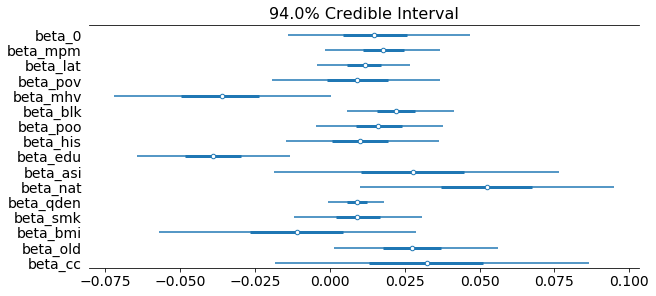

In [29]:
# Plot 94% credible intervals for each beta
axes = pm.plot_forest(trace_sing_int, kind='forestplot', combined=True, ridgeplot_overlap=3, figsize=(9, 4))

/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

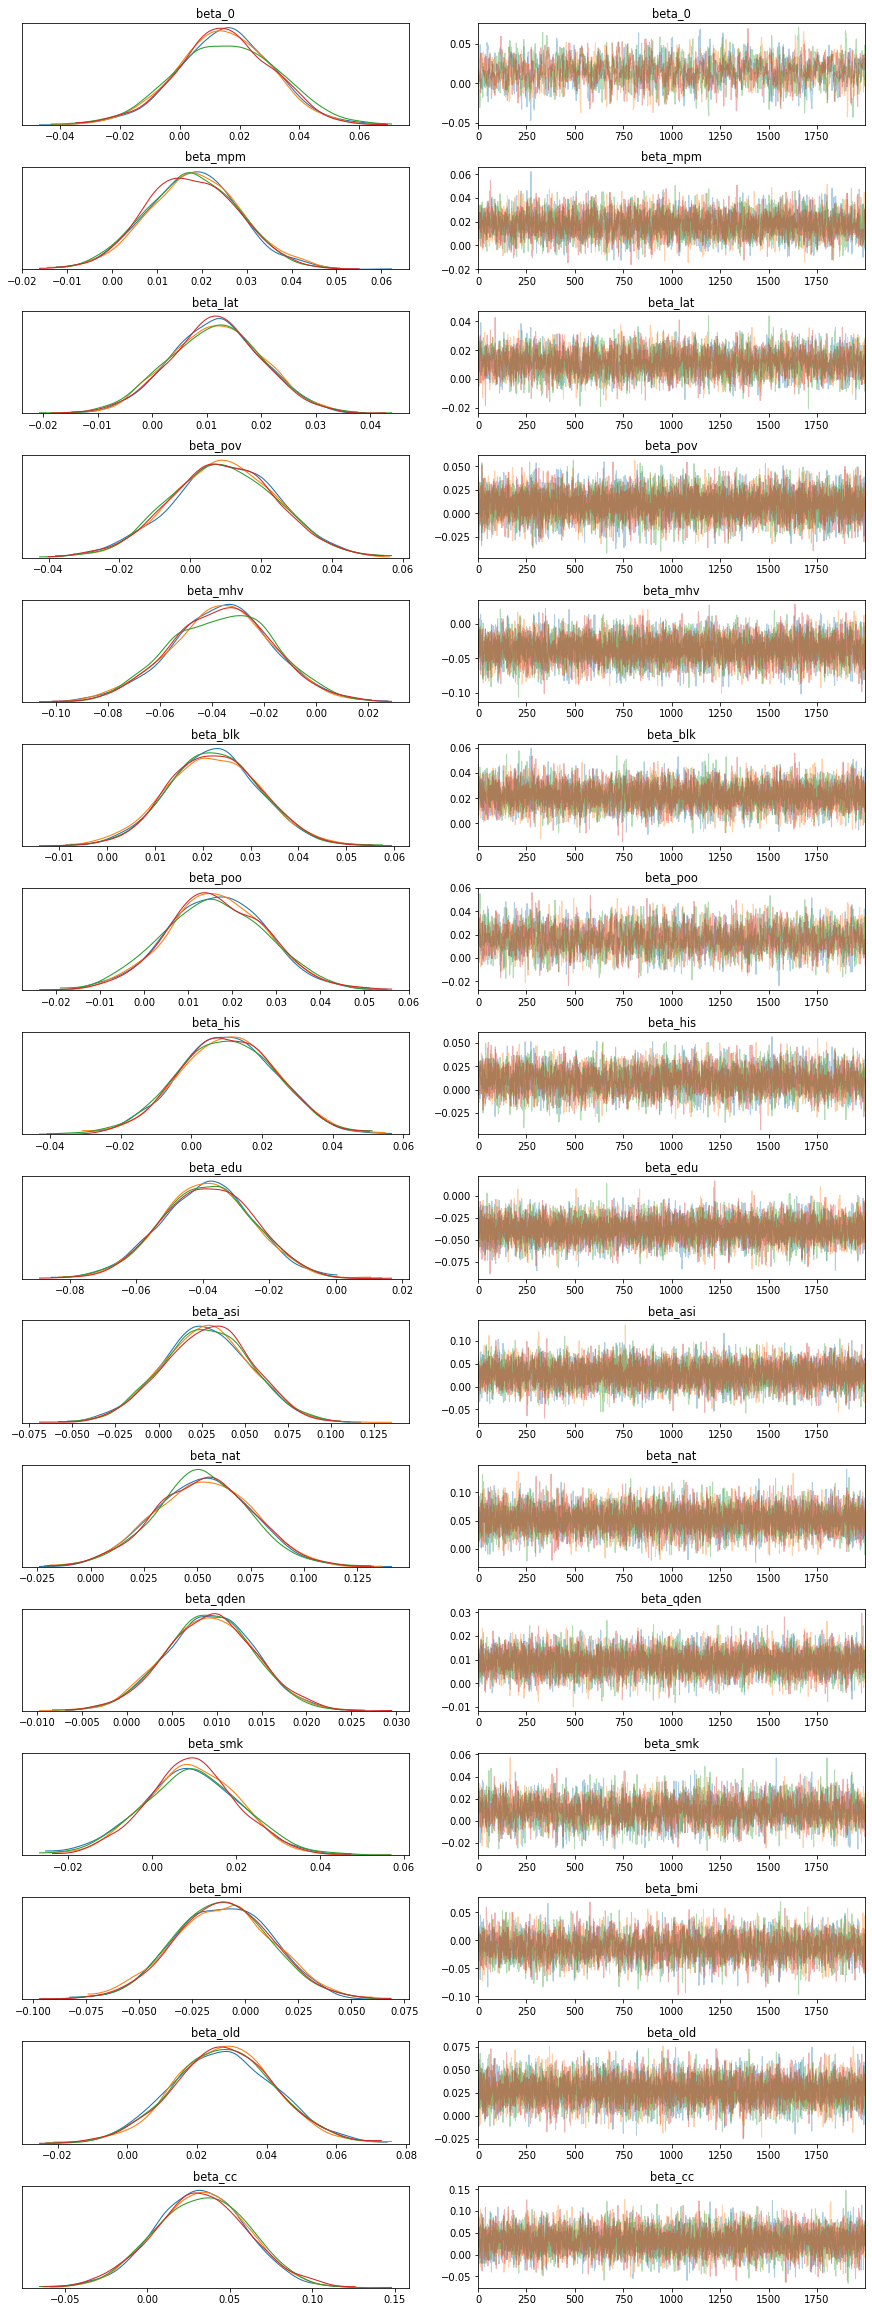

In [30]:
# Plot traceplots for all predictors
pm.traceplot(trace_sing_int)
plt.show()

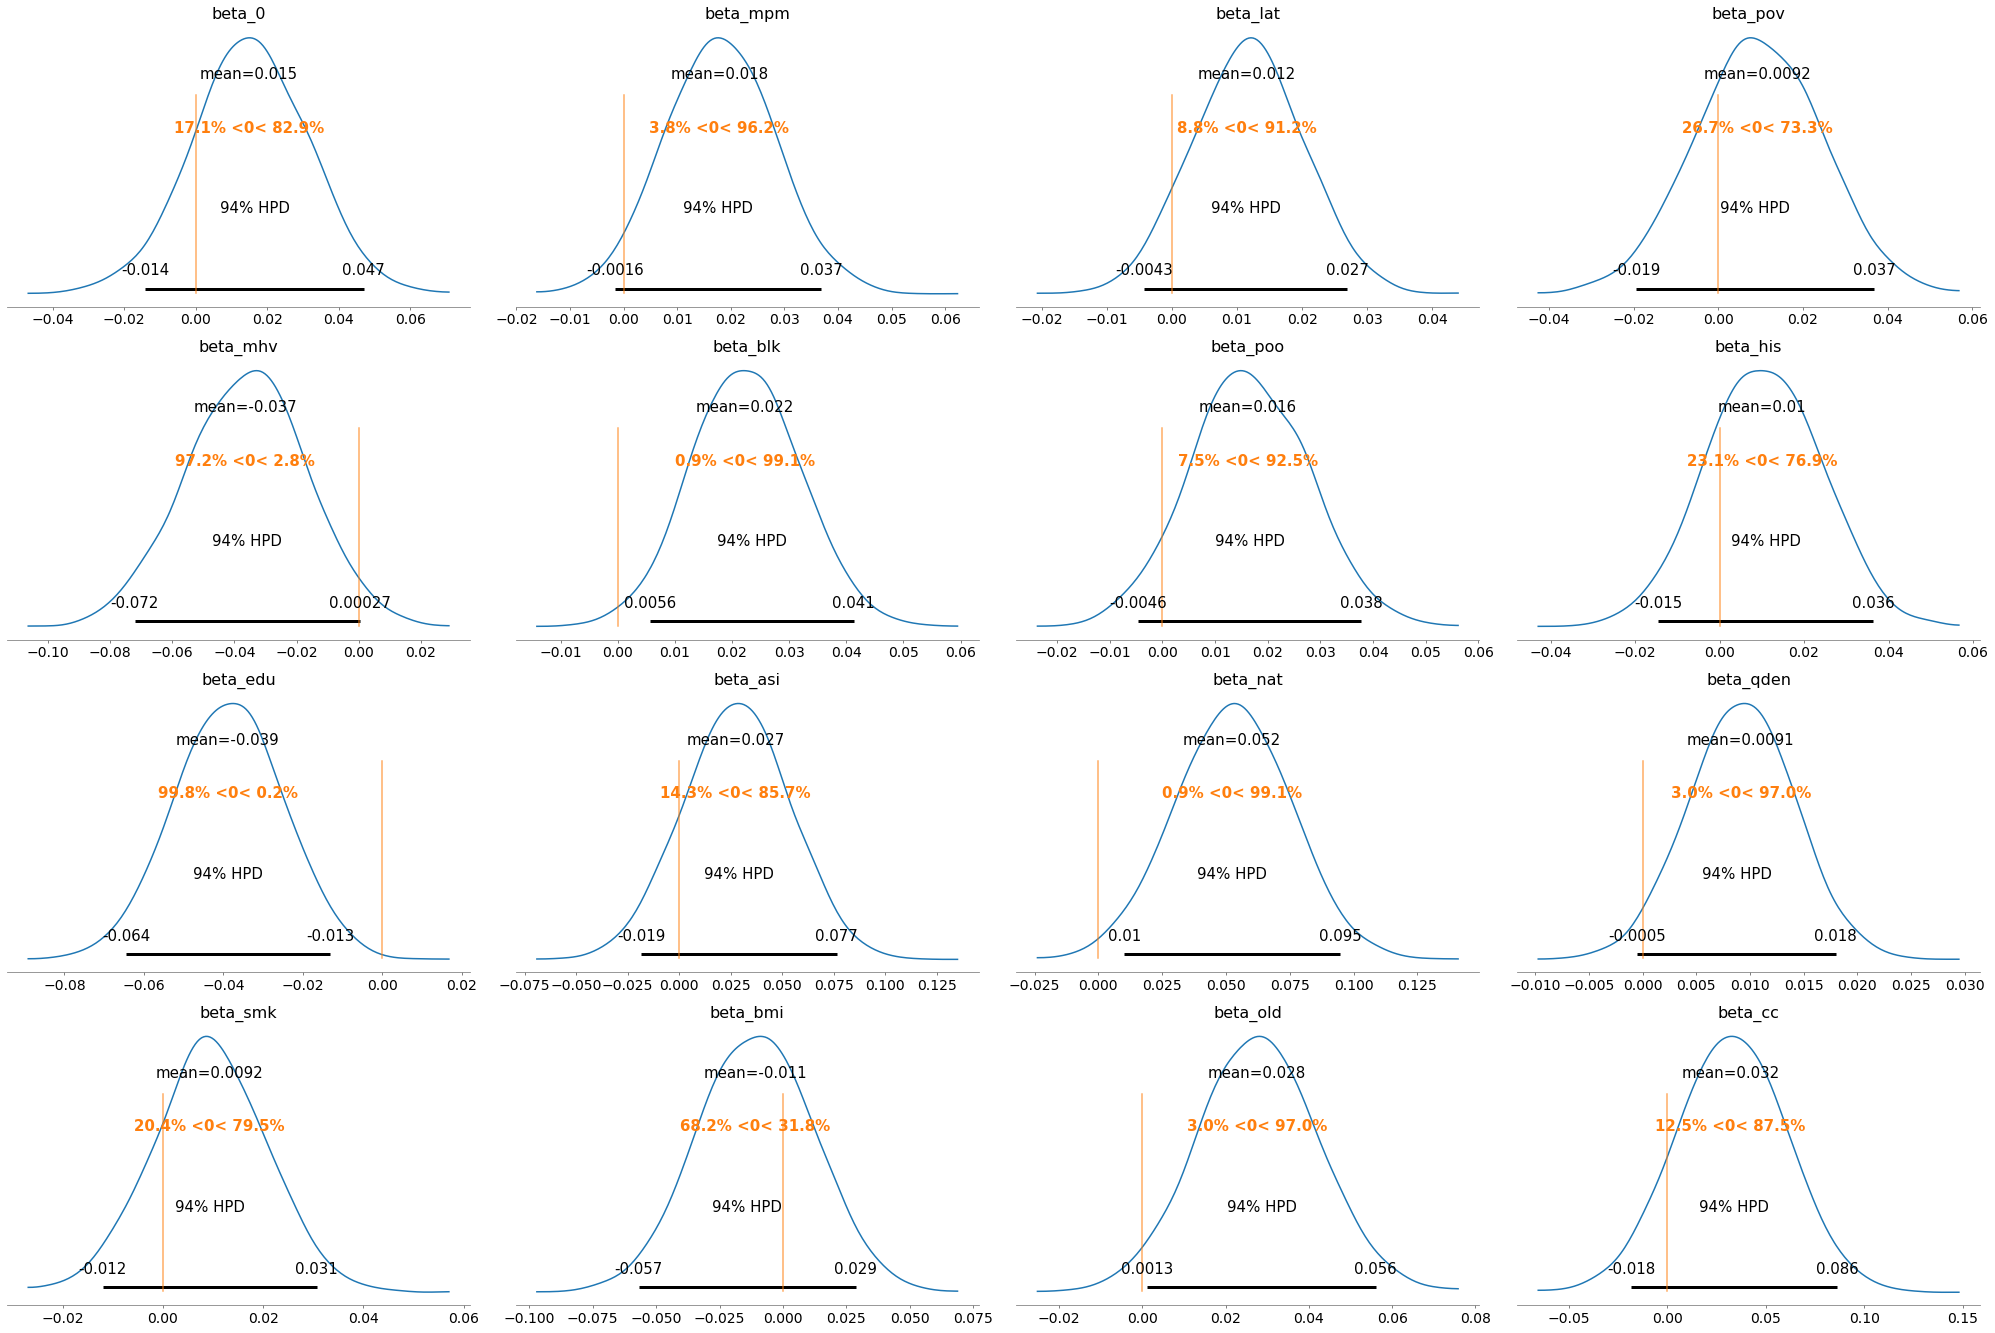

In [31]:
# Plot posterior distributions of parameters
pm.plots.plot_posterior(trace_sing_int, ref_val=0)
plt.show()

**The mixed-intercept model, population density quintile**

Assume a model
$$Y_i \sim \mathcal{N} (\mu_i, 0.01), \mu_i = \beta_{0i} + \sum_k \beta_k x_k$$ for $Y_i$ the death rate of a region with quintile population density $i$ and $\beta_{0i}, \beta_k \sim \mathcal{N} (0, 10000)$.

We examine convergence, 94% confidence intervals, and traceplots.

In [76]:
# Start with making the q_popdensity take integer categorical values
X_train['q_popdensity'] = 3*X_train['q_popdensity']
X_test['q_popdensity'] = 3*X_test['q_popdensity']
X_train['q_popdensity'] = X_train['q_popdensity'].astype(int)
X_test['q_popdensity'] = X_test['q_popdensity'].astype(int)

/Users/Josh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Josh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [78]:
# Fit mixed intercept model to training data
mixed_qpop_model = pm.Model()

with mixed_qpop_model:
    
    # Prior for intercept term
    beta_0 = pm.Normal('beta_0', mu=0, sd=100, shape=4)
    
    # Priors for linear terms
    beta_mpm = pm.Normal('beta_mpm', mu=0, sd=100)
    beta_lat = pm.Normal('beta_lat', mu=0, sd=100)
    beta_pov = pm.Normal('beta_pov', mu=0, sd=100)
    beta_mhv = pm.Normal('beta_mhv', mu=0, sd=100)
    beta_blk = pm.Normal('beta_blk', mu=0, sd=100)
    beta_poo = pm.Normal('beta_poo', mu=0, sd=100)
    beta_his = pm.Normal('beta_his', mu=0, sd=100)
    beta_edu = pm.Normal('beta_edu', mu=0, sd=100)
    beta_asi = pm.Normal('beta_asi', mu=0, sd=100)
    beta_nat = pm.Normal('beta_nat', mu=0, sd=100)
    beta_smk = pm.Normal('beta_smk', mu=0, sd=100)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=100)
    beta_old = pm.Normal('beta_old', mu=0, sd=100)
    beta_cc = pm.Normal('beta_cc', mu=0, sd=100)

    # Likelihood (sampling distribution) of observations
    lam_ij = beta_0[X_train['q_popdensity']] + beta_mpm*x_mpm + beta_lat*x_lat + beta_pov*x_pov \
                + beta_mhv*x_mhv + beta_blk*x_blk \
                + beta_poo*x_poo + beta_his*x_his + beta_edu*x_edu + beta_asi*x_asi + beta_nat*x_nat \
                + beta_smk*x_smk + beta_bmi*x_bmi + beta_old*x_old + beta_cc*x_cc
    Y_obs = pm.Normal('Y_obs', mu=lam_ij, sd=0.1, observed=X_train['death_rate'])

/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [79]:
# Sampling
with mixed_qpop_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 2000 posterior samples
    trace_mixed_qpop = pm.sample(2000, step, start=start)

/Users/Josh/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = 8,813.7:  34%|███▍      | 1708/5000 [00:00<00:01, 1817.20it/s]    


Optimization terminated successfully.
         Current function value: -8814.285513
         Iterations: 10
         Function evaluations: 1708


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_cc, beta_old, beta_bmi, beta_smk, beta_nat, beta_asi, beta_edu, beta_his, beta_poo, beta_blk, beta_mhv, beta_pov, beta_lat, beta_mpm, beta_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [07:59<00:00,  6.89draws/s]
/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
The number of effective samples is smaller than 25% for some parameters.


In [80]:
# Display results
results = pm.summary(trace_mixed_qpop)
results

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_0[0]  0.029  0.017  -0.002    0.061        0.0      0.0    1442.0   
beta_0[1]  0.034  0.016   0.003    0.064        0.0      0.0    1374.0   
beta_0[2]  0.037  0.016   0.007    0.067        0.0      0.0    1342.0   
beta_0[3]  0.040  0.016   0.008    0.069        0.0      0.0    1338.0   
beta_mpm   0.008  0.009  -0.010    0.025        0.0      0.0    4351.0   
beta_lat   0.007  0.008  -0.008    0.023        0.0      0.0    3724.0   
beta_pov   0.014  0.015  -0.012    0.043        0.0      0.0   10252.0   
beta_mhv   0.004  0.019  -0.031    0.040        0.0      0.0    6878.0   
beta_blk   0.005  0.009  -0.013    0.023        0.0      0.0    5679.0   
beta_poo  -0.002  0.011  -0.023    0.018        0.0      0.0    2667.0   
beta_his  -0.000  0.013  -0.026    0.024        0.0      0.0    4078.0   
beta_edu   0.006  0.014  -0.020    0.031        0.0      0.0    8929.0   
beta_asi   0.015  0.026  -0.035    0.061        0.0      0.0    9247.0   
beta_nat   0.018  0.023  -0.024    0.062        0.0      0.0    8280.0   
beta_smk  -0.008  0.011  -0.030    0.013        0.0      0.0    3659.0   
beta_bmi  -0.023  0.022  -0.064    0.019        0.0      0.0    4170.0   
beta_old   0.010  0.014  -0.017    0.036        0.0      0.0    7971.0   
beta_cc    0.012  0.028  -0.042    0.062        0.0      0.0    8357.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta_0[0]  1297.0    1438.0    1863.0    1.0  
beta_0[1]  1281.0    1370.0    1650.0    1.0  
beta_0[2]  1260.0    1336.0    1662.0    1.0  
beta_0[3]  1255.0    1332.0    1664.0    1.0  
beta_mpm   3792.0    4351.0    5126.0    1.0  
beta_lat   3724.0    3729.0    4997.0    1.0  
beta_pov   6838.0   10266.0    6191.0    1.0  
beta_mhv   5350.0    6815.0    6153.0    1.0  
beta_blk   5679.0    5668.0    6402.0    1.0  
beta_poo   2667.0    2659.0    3698.0    1.0  
beta_his   4078.0    4081.0    4960.0    1.0  
beta_edu   4378.0    8953.0    5397.0    1.0  
beta_asi   6864.0    9235.0    7155.0    1.0  
beta_nat   5746.0    8260.0    6540.0    1.0  
beta_smk   3659.0    3666.0    4549.0    1.0  
beta_bmi   3846.0    4169.0    4875.0    1.0  
beta_old   5200.0    7969.0    5991.0    1.0  
beta_cc    4920.0    8383.0    6005.0    1.0

/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


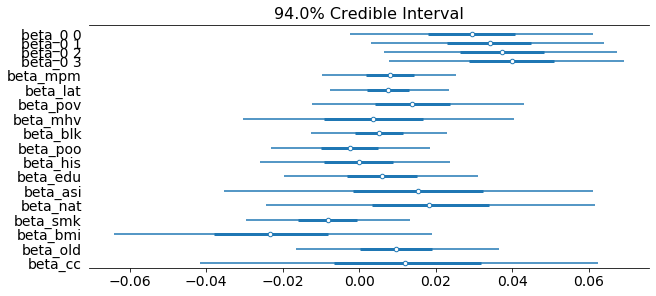

In [81]:
# Plot 94% credible intervals for each beta
axes = pm.plot_forest(trace_mixed_qpop, kind='forestplot', combined=True, ridgeplot_overlap=3, figsize=(9, 4))

/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

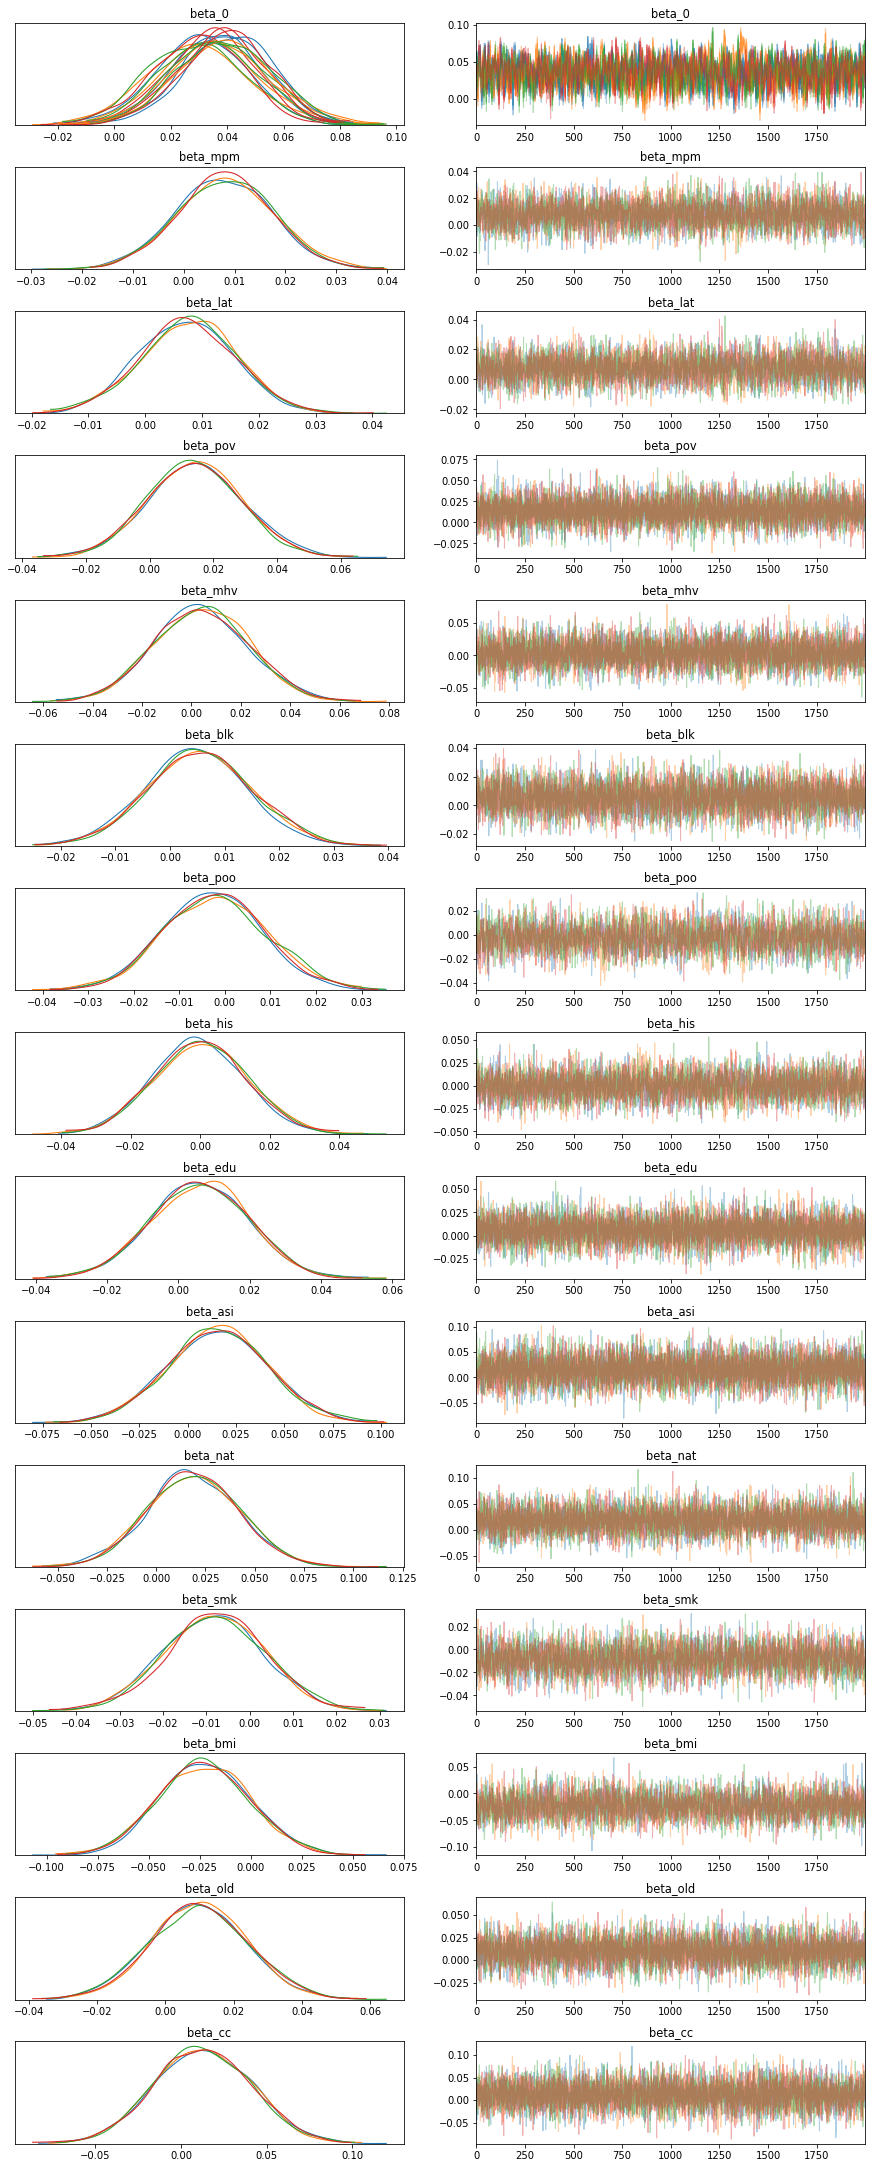

In [82]:
# Plot traceplots for all predictors
pm.traceplot(trace_mixed_qpop)
plt.show()

/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


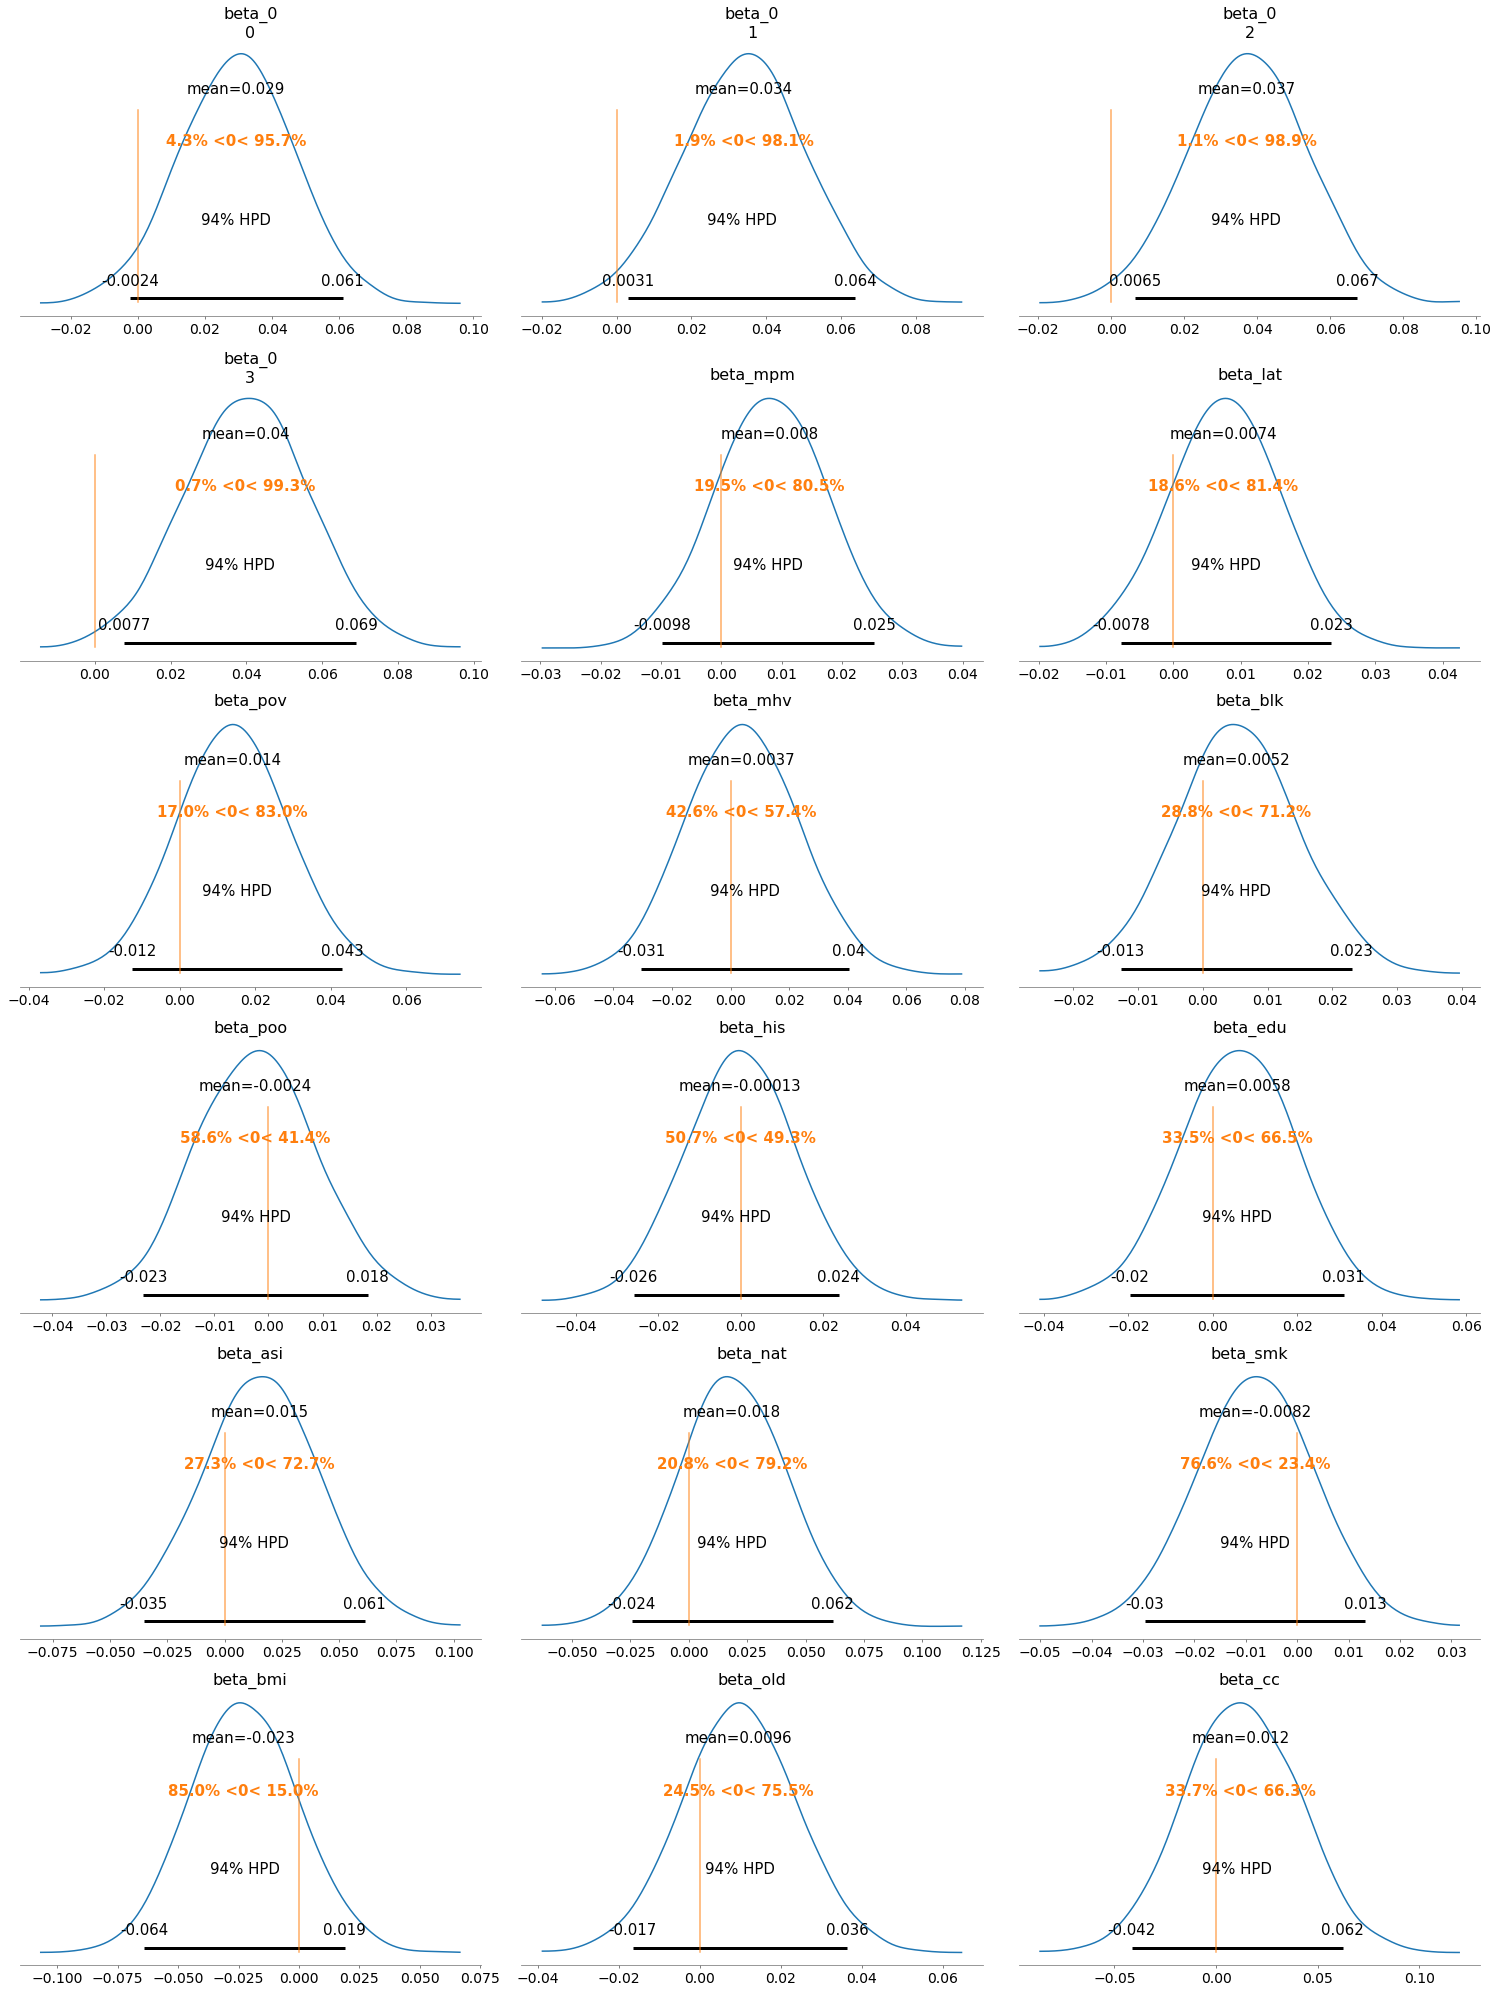

In [83]:
# Plot posterior distributions of parameters
pm.plots.plot_posterior(trace_mixed_qpop, ref_val=0)
plt.show()

**The mixed-intercept model, zero vs. nonzero deaths**

Assume a model
$$Y_j \sim \mathcal{N} (\mu_j, 0.01), \mu_j = \beta_{0j} + \sum_k \beta_k x_k$$ for $Y_j$ the death rate of a region where $j$ is an indicator for zero deaths, and $\beta_{0j}, \beta_k \sim \mathcal{N} (0, 10000)$.

We examine convergence, 94% confidence intervals, and traceplots.

In [84]:
# 1 if zero deaths in county else 0
X_train['zero_indicator'] = np.where(X_train['cum_deaths']==0, 1, 0)
X_test['zero_indicator'] = np.where(X_test['cum_deaths']==0, 1, 0)

/Users/Josh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Josh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
# Repeat sec. 2
x_zi = X_train['zero_indicator']

# Fit model to training data
zi_model = pm.Model()

with zi_model:
    
    # Prior for intercept term
    beta_0 = pm.Normal('beta_0', mu=0, sd=100, shape=4)
    
    # Priors for linear terms
    beta_mpm = pm.Normal('beta_mpm', mu=0, sd=100)
    beta_lat = pm.Normal('beta_lat', mu=0, sd=100)
    beta_pov = pm.Normal('beta_pov', mu=0, sd=100)
    beta_mhv = pm.Normal('beta_mhv', mu=0, sd=100)
    beta_blk = pm.Normal('beta_blk', mu=0, sd=100)
    beta_poo = pm.Normal('beta_poo', mu=0, sd=100)
    beta_his = pm.Normal('beta_his', mu=0, sd=100)
    beta_edu = pm.Normal('beta_edu', mu=0, sd=100)
    beta_asi = pm.Normal('beta_asi', mu=0, sd=100)
    beta_nat = pm.Normal('beta_nat', mu=0, sd=100)
    beta_smk = pm.Normal('beta_smk', mu=0, sd=100)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=100)
    beta_old = pm.Normal('beta_old', mu=0, sd=100)
    beta_cc = pm.Normal('beta_cc', mu=0, sd=100)
    beta_zi = pm.Normal('beta_zi', mu=0, sd=100)

    # Likelihood (sampling distribution) of observations
    lam_ij = beta_0[X_train['q_popdensity']] + beta_mpm*x_mpm + beta_lat*x_lat + beta_pov*x_pov \
                + beta_mhv*x_mhv + beta_blk*x_blk \
                + beta_poo*x_poo + beta_his*x_his + beta_edu*x_edu + beta_asi*x_asi + beta_nat*x_nat \
                + beta_smk*x_smk + beta_bmi*x_bmi + beta_old*x_old + beta_cc*x_cc + beta_zi*x_zi
    Y_obs = pm.Normal('Y_obs', mu=lam_ij, sd=0.1, observed=X_train['death_rate'])

In [102]:
# Sampling
with zi_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 2000 posterior samples
    zi_trace = pm.sample(2000, step, start=start)

/Users/Josh/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = 9,200.6:  36%|███▌      | 1808/5000 [00:00<00:01, 1950.24it/s]    


Optimization terminated successfully.
         Current function value: -9208.251385
         Iterations: 10
         Function evaluations: 1808


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_zi, beta_cc, beta_old, beta_bmi, beta_smk, beta_nat, beta_asi, beta_edu, beta_his, beta_poo, beta_blk, beta_mhv, beta_pov, beta_lat, beta_mpm, beta_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [07:41<00:00,  5.30draws/s]
/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
The number of effective samples is smaller than 25% for some parameters.


In [103]:
# Display results
results = pm.summary(zi_trace)
results

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_0[0]  0.076  0.016   0.044    0.106        0.0      0.0    1635.0   
beta_0[1]  0.076  0.016   0.047    0.107        0.0      0.0    1562.0   
beta_0[2]  0.069  0.016   0.039    0.098        0.0      0.0    1550.0   
beta_0[3]  0.049  0.016   0.018    0.077        0.0      0.0    1555.0   
beta_mpm   0.007  0.009  -0.010    0.023        0.0      0.0    4485.0   
beta_lat   0.006  0.008  -0.009    0.022        0.0      0.0    3975.0   
beta_pov   0.009  0.015  -0.020    0.036        0.0      0.0    9441.0   
beta_mhv  -0.001  0.019  -0.035    0.036        0.0      0.0    7404.0   
beta_blk   0.006  0.009  -0.012    0.023        0.0      0.0    5810.0   
beta_poo   0.001  0.011  -0.020    0.020        0.0      0.0    2843.0   
beta_his  -0.002  0.014  -0.028    0.023        0.0      0.0    4103.0   
beta_edu   0.001  0.014  -0.024    0.027        0.0      0.0    9286.0   
beta_asi   0.018  0.025  -0.027    0.066        0.0      0.0    8815.0   
beta_nat   0.018  0.023  -0.026    0.059        0.0      0.0    8681.0   
beta_smk  -0.003  0.012  -0.024    0.019        0.0      0.0    3778.0   
beta_bmi  -0.019  0.022  -0.059    0.024        0.0      0.0    4416.0   
beta_old   0.003  0.014  -0.022    0.030        0.0      0.0    8331.0   
beta_cc    0.003  0.027  -0.048    0.053        0.0      0.0    8437.0   
beta_zi   -0.074  0.003  -0.079   -0.069        0.0      0.0    9121.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta_0[0]  1608.0    1640.0    2448.0    1.0  
beta_0[1]  1531.0    1568.0    2092.0    1.0  
beta_0[2]  1519.0    1554.0    2092.0    1.0  
beta_0[3]  1522.0    1559.0    2122.0    1.0  
beta_mpm   4485.0    4497.0    5618.0    1.0  
beta_lat   3975.0    3979.0    4733.0    1.0  
beta_pov   5590.0    9437.0    6029.0    1.0  
beta_mhv   4890.0    7410.0    6490.0    1.0  
beta_blk   5810.0    5803.0    6562.0    1.0  
beta_poo   2843.0    2841.0    3787.0    1.0  
beta_his   4103.0    4110.0    5497.0    1.0  
beta_edu   3862.0    9279.0    6142.0    1.0  
beta_asi   6585.0    8821.0    7052.0    1.0  
beta_nat   5744.0    8697.0    6215.0    1.0  
beta_smk   3523.0    3774.0    4543.0    1.0  
beta_bmi   4078.0    4421.0    4345.0    1.0  
beta_old   3964.0    8343.0    5921.0    1.0  
beta_cc    4739.0    8446.0    6666.0    1.0  
beta_zi    9085.0    9097.0    5066.0    1.0

/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


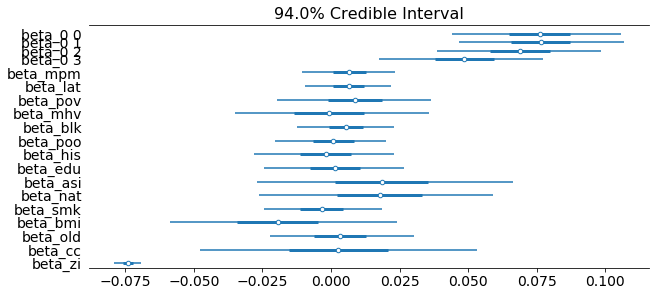

In [104]:
# Plot 94% credible intervals for each beta
axes = pm.plot_forest(zi_trace, kind='forestplot', combined=True, ridgeplot_overlap=3, figsize=(9, 4))

/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Josh/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't

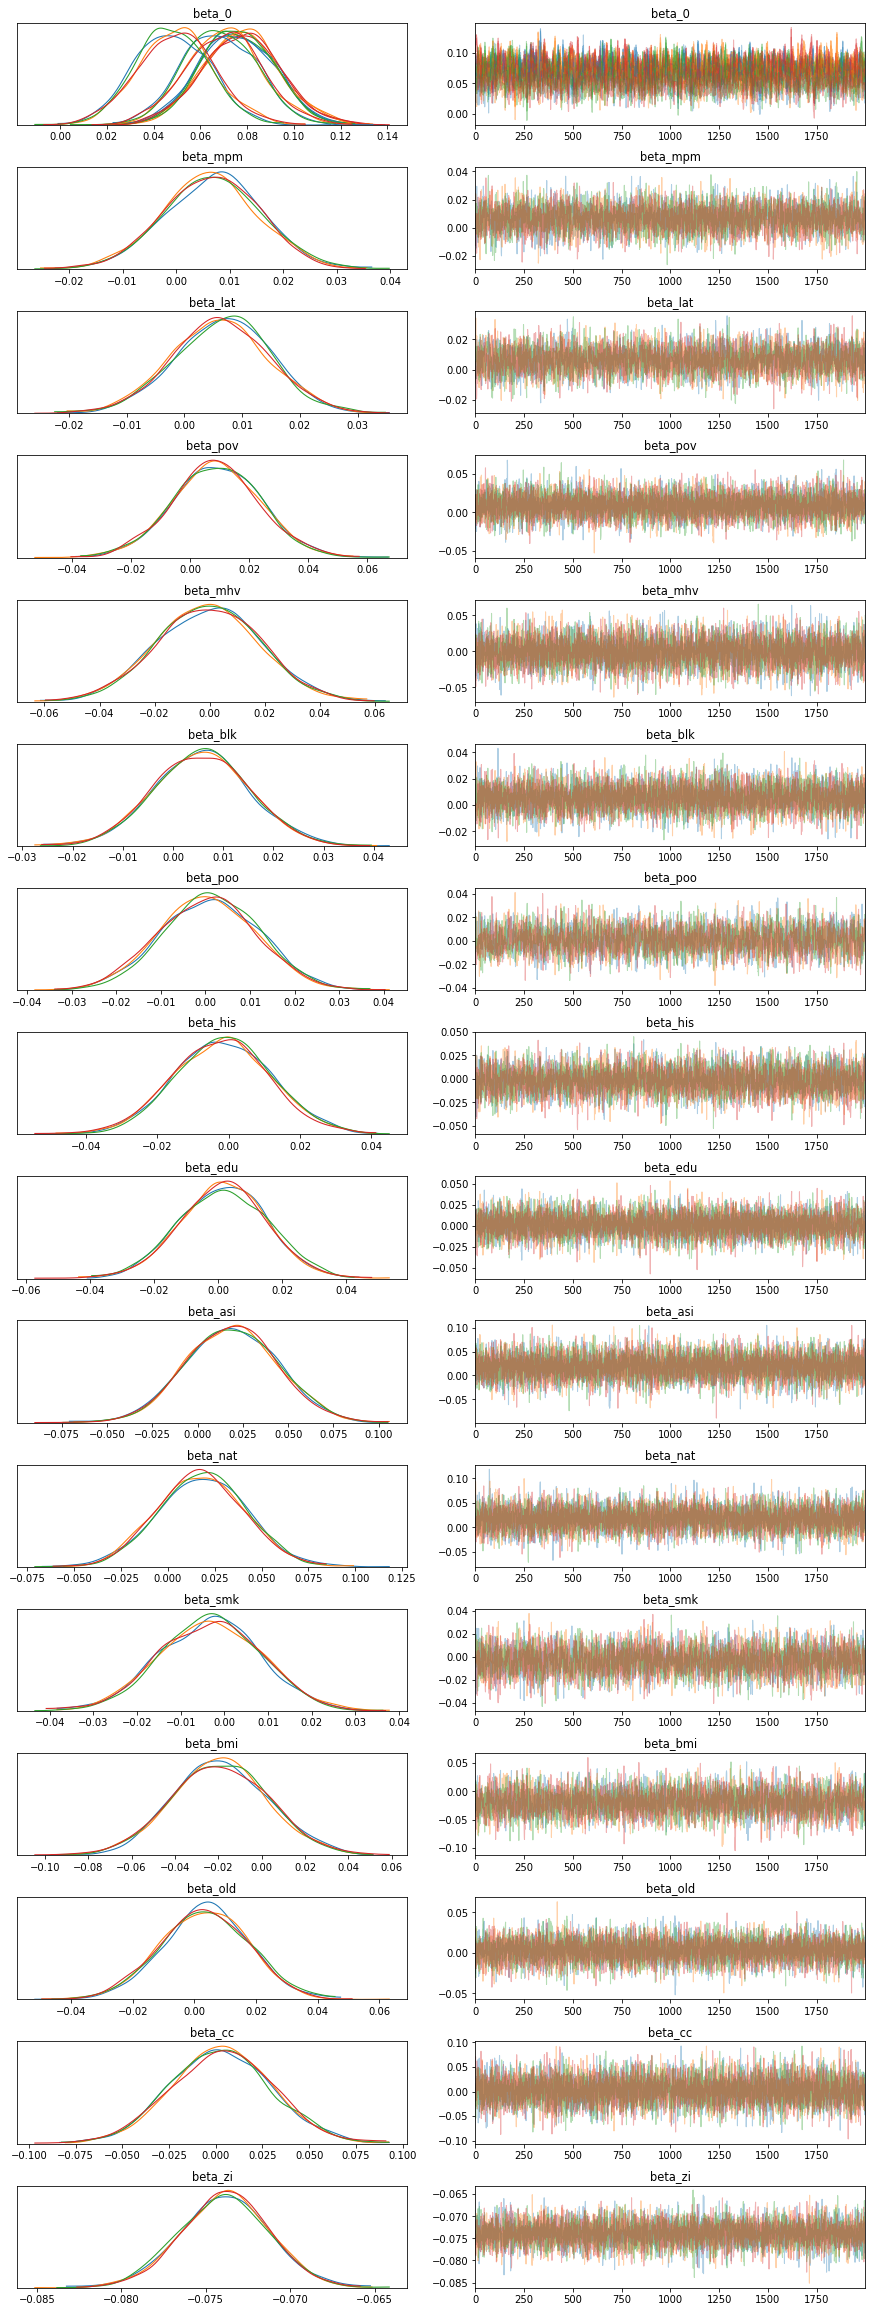

In [105]:
# Plot traceplots for all predictors
pm.traceplot(zi_trace)
plt.show()

/Users/Josh/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


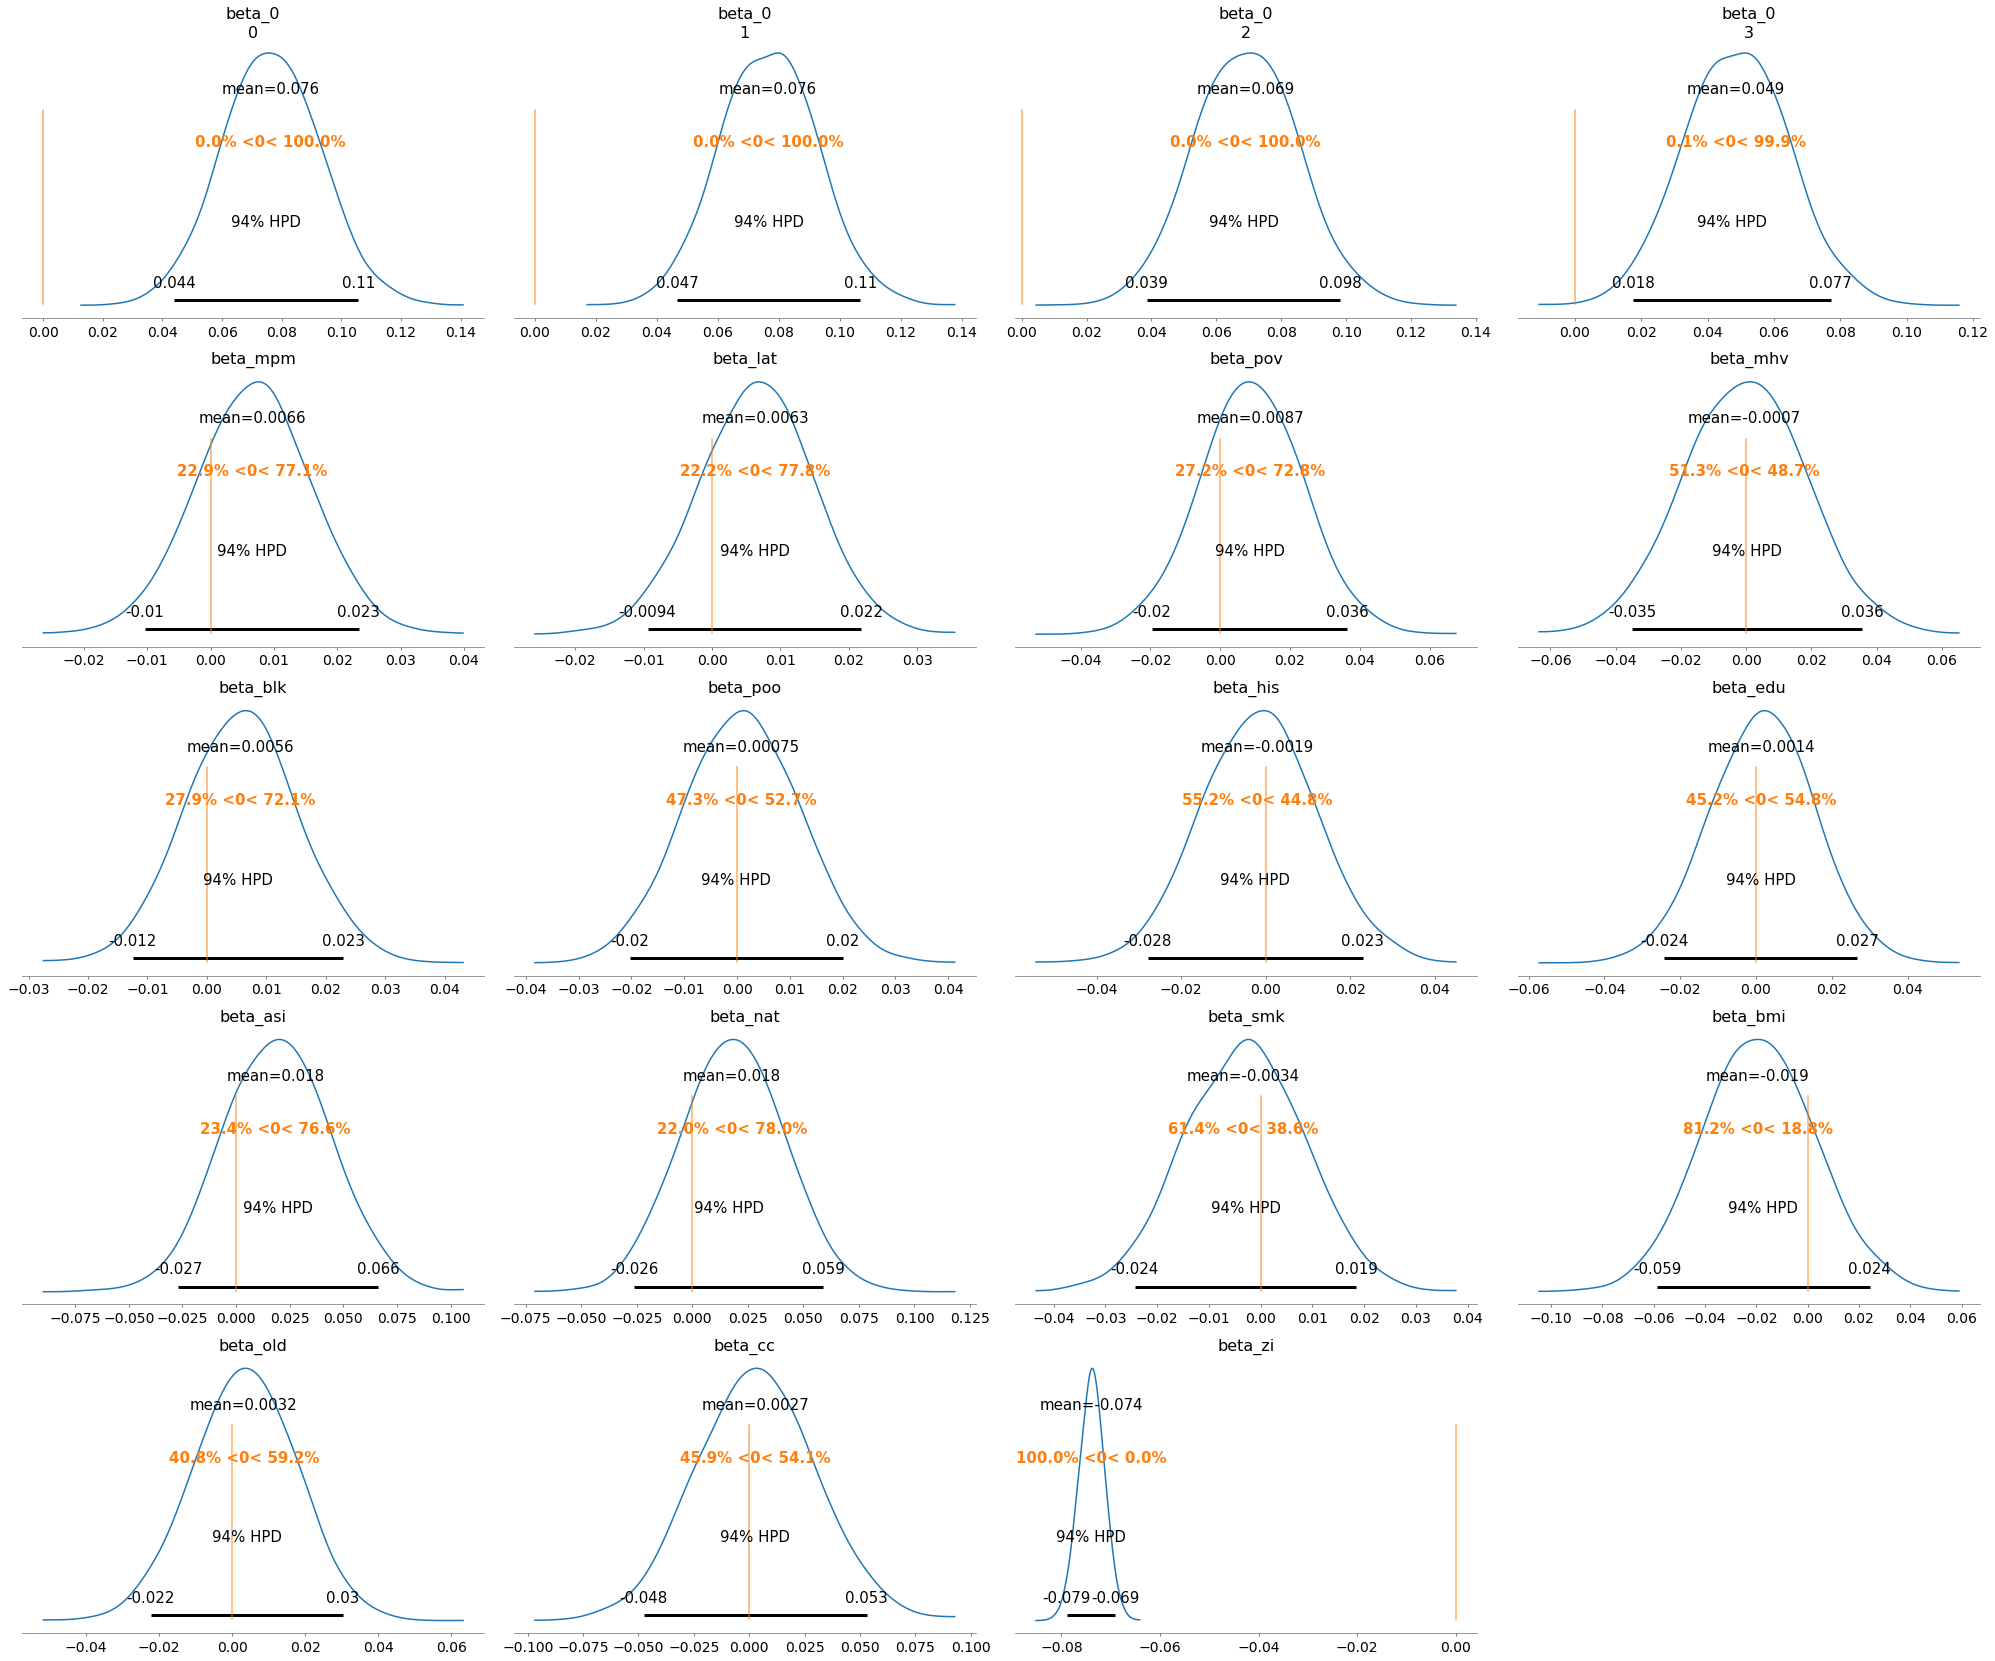

In [106]:
# Plot posterior distributions of parameters
pm.plots.plot_posterior(zi_trace, ref_val=0)
plt.show()

The final model illustrates the utility of its robustness. It is virtually impossible to predict a zero death rate based on statistics like the mean BMI and median household income alone. It's important to know whether or not the population has any confirmed deaths in the first place, and we can conclude that it might be a good idea to separate different counties out by their population densities.